In [5]:
# Import modules and packages
import numpy as np
import problemLibrary as pl
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute

degree = 3 # degree of graph
rounds = 1 # number of rounds

# Load the fixed angles from angles_regular_graphs.json taken from https://github.com/danlkv/fixed-angle-QAOA
angle_data = pl.fixed_angles_data[str(degree)][str(rounds)]
betas = angle_data['beta']
gammas = angle_data['gamma']
guarantee = angle_data['AR']

In [6]:
def create_QAOA_circuit(nodes, edges, betas, gammas):
    assert len(betas) == len(gammas), "Betas and Gammas arrays should be of the same length"
    rounds = len(betas)
    circuit = QuantumCircuit(nodes)
    for i in range(nodes):
        # Apply the Hadamard gate on each qubit
        circuit.h(i)

    for roundIndex in range(rounds):
        # For each round, apply RZZ gates followed by RX gates
        beta = betas[roundIndex]
        gamma = gammas[roundIndex]

        for i,j in edges:
            # exp(i gamma/2 Z_i Z_j)
            circuit.rzz( -gamma, i, j)
        for i in range(nodes):
            # exp(-i beta X_i)
            circuit.rx(2 * beta, i)
    
    return circuit


def get_QAOA_approxRatio(size, betas, gammas):
    """
    Obtain the approximation ratio using a state vector simulator, for a graph of given size (and degree 3; load from the problemLibrary), and with the given angles
    """
    # Load the problem
    nodes, edges = pl.read_maxcut_instance(size)
    optVal, solution = pl.read_maxcut_solution(size)
    # Create QAOA circuit
    circuit = create_QAOA_circuit(nodes, edges, betas, gammas)

    # Obtain probabilities using state vector simulation 
    sv = Aer.get_backend('statevector_simulator')
    sv_counts = execute(circuit, sv).result().get_counts()
    
    # Get energy expectation value
    ee = 0
    for (cut, count) in sv_counts.items():
        size = pl.eval_cut(nodes, edges, cut)
        ee = ee + size * count
    
    # Get approximation ratio
    ar = ee / optVal

    return ar    

In [7]:
size_list = list(range(4,17,2))
ar_list = [get_QAOA_approxRatio(size,betas, gammas) for size in size_list]


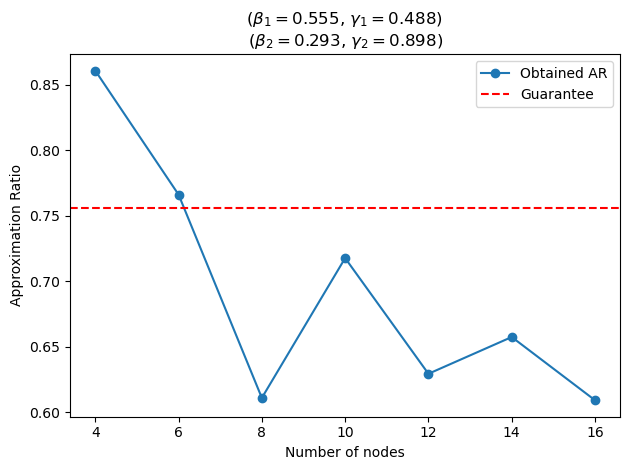

In [8]:
plt.plot(size_list, ar_list, '-o', label='Obtained AR')
plt.axhline(y=guarantee, ls='--', c='r', label='Guarantee')
angle_str = ""
for ind in range(rounds):
    angle_str += r"($\beta_{}={:.3f}$,".format(ind + 1, betas[ind])
    angle_str += r" $\gamma_{}={:.3f}$) ".format(ind + 1, gammas[ind]) + "\n"
angle_str = angle_str[:-2]
# and add the title to the plot
plt.title(angle_str)
plt.xlabel("Number of nodes")
plt.ylabel("Approximation Ratio")
plt.legend()
plt.tight_layout()
plt.savefig("Rounds={}.png".format(rounds))
